In [771]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
%matplotlib inline

# Data Reading

In [772]:
data = pd.read_csv('../data/hits.csv', index_col=0)
data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Z,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label
79,2,2.0,-211.0,10002284.0,1,0,0,0,284,0.866347,...,2581.149902,0.042245,-250.000000,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0.0
111,2,2.0,-211.0,42012282.0,4,2,0,1,282,0.867240,...,3542.247803,0.478996,-248.589486,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0.0
81,2,2.0,-211.0,11012288.0,1,1,0,1,288,0.866625,...,2592.249023,0.310706,-248.587499,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0.0
43,2,3.0,-13.0,11012286.0,1,1,0,1,286,-0.239448,...,2592.249268,0.117904,-248.894287,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1.0
88,2,2.0,-211.0,20012285.0,2,0,0,1,285,0.866401,...,2782.250977,0.437575,-250.000000,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0.0


In [773]:
data.columns

Index([u'EventID', u'TrackID', u'PdgCode', u'DetectorID', u'StatNb', u'ViewNb',
       u'PlaneNb', u'LayerNb', u'StrawNb', u'Px', u'Py', u'Pz', u'X', u'Y',
       u'Z', u'dist2Wire', u'Wx1', u'Wx2', u'Wy1', u'Wy2', u'Wz', u'Wz1',
       u'Wz2', u'Label'],
      dtype='object')

# Stage 2.1

Choosing an event

In [817]:
event = data[data.EventID==2]

# Function Initialization

## distance between 2 skew lines

In [818]:
def cross(vec1, vec2):
    return T.as_tensor([
        vec1[1]*vec2[2] - vec1[2]*vec2[1],
        vec1[2]*vec2[0] - vec1[0]*vec2[2],
        vec1[0]*vec2[1] - vec1[1]*vec2[0]])

In [819]:
#arr = np.array(x1, y1, z1, x2, y2, z2)
def points2vec(arr):
    a0 = np.array([arr[0], arr[1], arr[2]])
    a = np.array([arr[3]-arr[0], arr[4]-arr[1], arr[5]-arr[2]])
    return a0, a

In [820]:
a0 = T.vector("my_vector", dtype='float64')
a = T.vector("my_vector", dtype='float64')
b0 = T.vector("my_vector", dtype='float64')
b = T.vector("my_vector", dtype='float64')

In [821]:
dist = T.sqrt(T.sum((a*cross(b, (a0-b0)))**2))/T.sqrt(T.sum(cross(a,b)**2))

In [822]:
distance_between_skew_lines = theano.function([a0, a, b0, b], dist)

## retina artifitial response

In [646]:
points = T.matrix("points", dtype='float64')
directions = T.matrix("directions", dtype='float64')
track0 = T.vector("track0", dtype='float64')
track = T.vector("track", dtype='float64')
sigma = T.scalar("sigma", dtype="float64")

In [647]:
rs, updates = theano.scan(fn = lambda point, direction, tr0, tr, s:
                         T.exp(-(T.sqrt(T.sum((direction*cross((point-tr0), tr))**2))/T.sqrt(T.sum(cross(direction,tr))**2))**2/s**2),
                         sequences=[points, directions],
                         non_sequences=[track0, track, sigma])

In [648]:
r = rs.sum()
R = theano.function([track0, track, points, directions, sigma], r)

# Test

## test distance between 2 skew lines

In [778]:
track1 = event[(event.TrackID==2)&(event.StatNb<3)]
track2 = event[(event.TrackID==3)&(event.StatNb<3)]
noise = event[(event.TrackID!=2)&(event.TrackID!=3)&(event.TrackID<3)]

In [797]:
x0=track1.X.values[0]
x1=track1.X.values[15]
y0=track1.Y.values[0]
y1=track1.Y.values[15]
z0=track1.Z.values[0]
z1=track1.Z.values[15]

In [798]:
track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))

In [807]:
index = 6
params = track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[index]
tube_point, tube_direction = points2vec(params)
track1.dist2Wire.values[index]

0.074287596948099999

In [808]:
distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction)

array(0.6243507584554865)

In [812]:
tube_direction

array([ 500.,    0.,    0.])

### Distribution of absolute error

In [823]:
real = []
exp = []
for event_i in set(data.EventID.values):
    event = data[data.EventID==event_i]
    track1 = event[(event.TrackID==2)&(event.StatNb<3)]
    if len(track1)>1:
        x0=track1.X.values[0]
        x1=track1.X.values[1]
        y0=track1.Y.values[0]
        y1=track1.Y.values[1]
        z0=track1.Z.values[0]
        z1=track1.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    for i in range(len(track1)):
        params = track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i]
        tube_point, tube_direction = points2vec(params)
        exp.append(distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction))
        real.append(track1.dist2Wire.values[i])
        
    track2 = event[(event.TrackID==3)&(event.StatNb<3)]
    if len(track2)>1:
        x0=track2.X.values[0]
        x1=track2.X.values[1]
        y0=track2.Y.values[0]
        y1=track2.Y.values[1]
        z0=track2.Z.values[0]
        z1=track2.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    for i in range(len(track2)):
        params = track2[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i]
        tube_point, tube_direction = points2vec(params)
        exp.append(distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction))
        real.append(track2.dist2Wire.values[i])

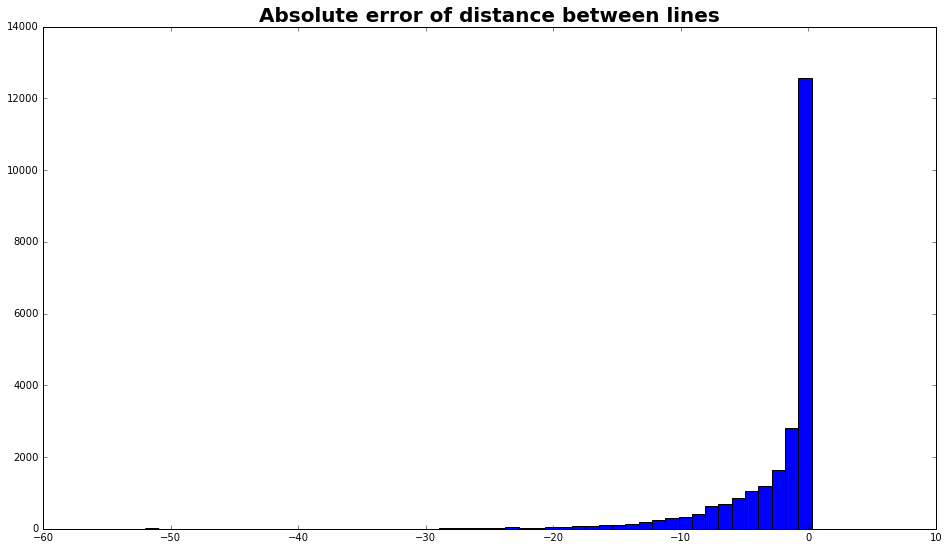

In [824]:
plt.figure(figsize=(16,9))
plt.title("Absolute error of distance between lines", fontsize=20, fontweight='bold')
arr = plt.hist(np.array(real)-np.array(exp), bins=50)

## test retina artifitial response

In [729]:
A0 = []
A = []
for i in range(len(track1.index)):
    a0, a = points2vec(track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i])
    A0.append(a0)
    A.append(a)
A0 = np.array(A0)
A = np.array(A)

In [730]:
R(track_point, track_direction, A0, A, 10)

array(8.991786218302694)

In [731]:
track1

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Z,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label
79,2,2.0,-211.0,10002284.0,1,0,0,0,284,0.866347,...,2581.149902,0.042245,-250.000000,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0.0
81,2,2.0,-211.0,11012288.0,1,1,0,1,288,0.866625,...,2592.249023,0.310706,-248.587499,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0.0
88,2,2.0,-211.0,20012285.0,2,0,0,1,285,0.866401,...,2782.250977,0.437575,-250.000000,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0.0
85,2,2.0,-211.0,13002284.0,1,3,0,0,284,0.866653,...,2611.149902,0.097779,-250.000000,250.000000,0.868600,0.868600,2611.1500,2611.1500,2611.1500,0.0
86,2,2.0,-211.0,13102284.0,1,3,1,0,284,0.866610,...,2613.750732,0.337356,-250.000000,250.000000,0.428600,0.428600,2613.7500,2613.7500,2613.7500,0.0
87,2,2.0,-211.0,20002284.0,2,0,0,0,284,0.866590,...,2781.148926,0.439979,-250.000000,250.000000,0.868600,0.868600,2781.1500,2781.1500,2781.1500,0.0
97,2,2.0,-211.0,23102284.0,2,3,1,0,284,0.868264,...,2813.749756,0.074288,-250.000000,250.000000,0.428600,0.428600,2813.7500,2813.7500,2813.7500,0.0
89,2,2.0,-211.0,20102284.0,2,0,1,0,284,0.866252,...,2783.750000,0.005764,-250.000000,250.000000,0.428600,0.428600,2783.7500,2783.7500,2783.7500,0.0
93,2,2.0,-211.0,22012281.0,2,2,0,1,281,0.866556,...,2802.250000,0.034292,-248.436092,249.661257,28.790790,-14.787082,2802.3793,2802.3793,2802.3793,0.0
82,2,2.0,-211.0,11112288.0,1,1,1,1,288,0.866595,...,2594.850342,0.121902,-248.549150,249.548199,-27.498526,16.079345,2594.9793,2594.9793,2594.9793,0.0


# Stage 2.2

# 2D projections

function converting line from $~~~\frac{x-x_{0}}{l} = \frac{y-y_{0}}{m} = z~~~$ to $~~~\vec{a_{0}}+\overrightarrow{a}$

In [691]:
def params2vec(l, x0, m, y0):
    z1 = 0
    z2 = 1
    x1 = x0
    x2 = 1 * l + x0
    y1 = y0
    y2 = 1 * m + y0
    a0 = np.array([x1, y1, z1])
    a = np.array([x2-x1, y2-y1, z2-z1])
    return a0, a

take hits before magnet only

In [692]:
event_before_magnet = event[event.StatNb<3]

In [693]:
A0 = []
A = []
for i in range(len(event_before_magnet.index)):
    a0, a = points2vec(event_before_magnet[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i])
    A0.append(a0)
    A.append(a)
A0 = np.array(A0)
A = np.array(A)

In [750]:
size = 20
ms = np.linspace(-0.2, 0.2, size)
y0s = np.linspace(-200, 200, size)
ls = np.linspace(-0.5, -0.3, size)
x0s = np.linspace(400, 900, size)

In [751]:
projection_on_yz = np.zeros((len(y0s), len(ms)), dtype="float64")
projection_on_xz = np.zeros((len(x0s), len(ls)), dtype="float64")

In [752]:
for i in range(len(y0s)):
    for j in range(len(ms)):
        max_R = 0
        for s in range(len(x0s)):
            for t in range(len(ls)):
                track_point, track_direction = params2vec(ls[t], x0s[s], ms[j], y0s[i])
                iR = R(track_point, track_direction, A0, A, 5)
                if iR > max_R: max_R = iR
        projection_on_yz[i, j] = max_R

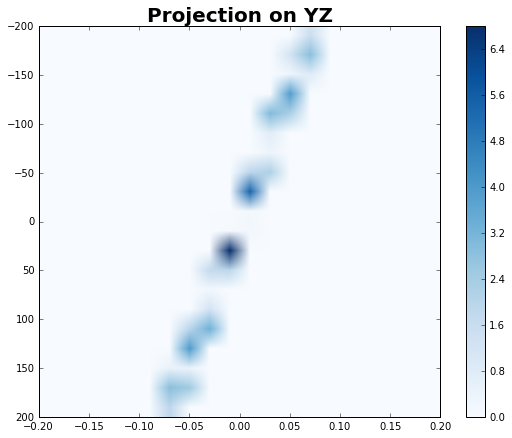

In [753]:
plt.figure(figsize=(9, 7))
plt.title("Projection on YZ", fontsize=20, fontweight='bold')
plt.imshow(projection_on_yz, aspect='auto', cmap="Blues", extent=(ms.min(), ms.max(), y0s.max(), y0s.min()))
plt.colorbar()

In [754]:
for i in range(len(x0s)):
    for j in range(len(ls)):
        max_R = 0
        for s in range(len(y0s)):
            for t in range(len(ms)):
                track_point, track_direction = params2vec(ls[j], x0s[i], ms[t], y0s[s])
                iR = R(track_point, track_direction, A0, A, 5)
                if iR > max_R: max_R = iR
        projection_on_xz[i, j] = max_R

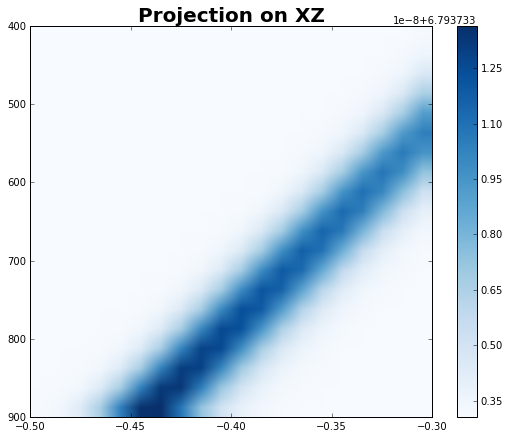

In [755]:
plt.figure(figsize=(9, 7))
plt.title("Projection on XZ", fontsize=20, fontweight='bold')
plt.imshow(projection_on_xz, aspect='auto', cmap="Blues", extent=(ls.min(), ls.max(), x0s.max(), x0s.min()))
plt.colorbar()